In [1]:
from os.path import join

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

import requests

import PIL
from PIL import Image

C:\Users\Alexandr\.conda\envs\common\lib\site-packages\ipykernel\parentpoller.py:113: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [18]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.ImageFolder(join('ants_and_bees', 'train'), transform=transform_train)
validation_dataset = datasets.ImageFolder(join('ants_and_bees', 'val'), transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=50, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=50, shuffle=False)

In [19]:
data_classes = ['ant', 'bee']

In [5]:
def img_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

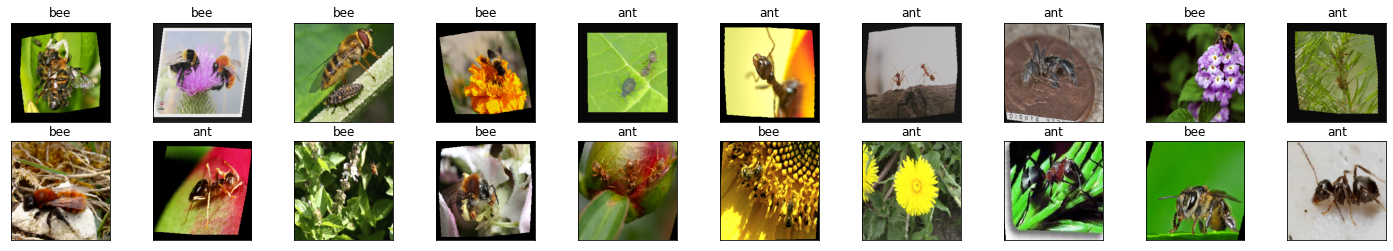

In [32]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title(data_classes[labels[idx].item()])

In [14]:
alexnet_model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Alexandr/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [8]:
vgg16_model = models.vgg16(pretrained=True)

In [34]:
print(alexnet_model)

NameError: name 'alexnet_model' is not defined

In [35]:
# freezing features weights:
for param in alexnet_model.features.parameters():
    param.requires_grad = False

NameError: name 'alexnet_model' is not defined

In [28]:
n_inputs = alexnet_model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(data_classes))
alexnet_model.classifier[6] = last_layer

In [29]:
print(alexnet_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# freezing features weights:
for param in vgg16_model.features.parameters():
    param.requires_grad = False

In [11]:
n_inputs = vgg16_model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(data_classes))
vgg16_model.classifier[6] = last_layer

In [12]:
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
model = vgg16_model
model.to(device)
print()

In [21]:
def calculate_corrects_and_losses(loader, model, loss_function):
    loss = 0.0
    correct = 0.0
    
    running_loss = 0.0
    running_correct = 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            res = loss_function(outputs, labels)
            running_loss += res.item()

            _, pred_labels = torch.max(outputs, 1)
            running_correct += torch.sum(pred_labels == labels.data)
        
    loss = running_loss / len(loader)
    correct = running_correct.float() / len(loader.dataset)
        
    return loss, correct

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [23]:
epochs = 5
losses = []
corrects = []

val_losses = []
val_corrects = []

for e in range(epochs):
    running_loss = 0.0
    running_correct = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, pred_labels = torch.max(outputs, 1)
        running_correct += torch.sum(pred_labels == labels.data)
        
    epoch_loss = running_loss / len(training_loader.dataset)
    losses.append(epoch_loss)
    
    epoch_correct = running_correct.float() / len(training_loader.dataset)
    corrects.append(epoch_correct)
    
    print('training loss: {:.4f} corrects: {:.4f}'.format(epoch_loss, epoch_correct))
    
    val_epoch_loss, val_epoch_correct = calculate_corrects_and_losses(validation_loader, model, criterion)
    val_losses.append(val_epoch_loss)
    val_corrects.append(val_epoch_correct)

training loss: 0.0098 corrects: 0.7664
training loss: 0.0048 corrects: 0.8934
training loss: 0.0027 corrects: 0.9795
training loss: 0.0015 corrects: 0.9631
training loss: 0.0017 corrects: 0.9631


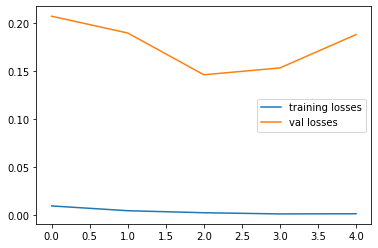

In [24]:
plt.plot(losses, label='training losses')
plt.plot(val_losses, label='val losses')
plt.legend()

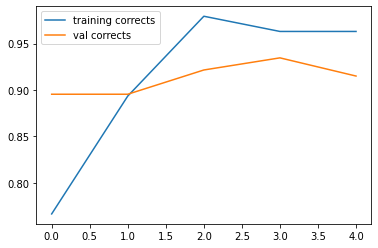

In [25]:
plt.plot([x.cpu() for x in corrects], label='training corrects')
plt.plot([x.cpu() for x in val_corrects], label='val corrects')
plt.legend()

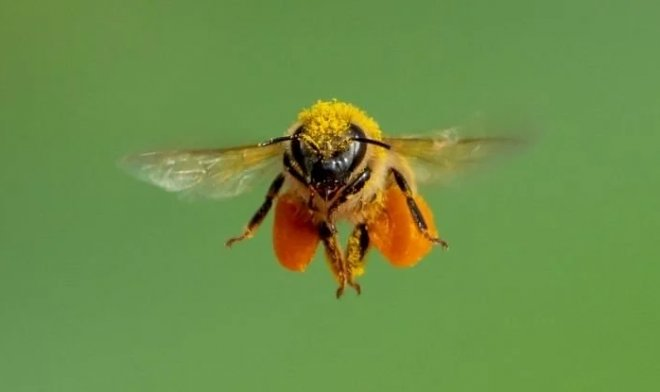

In [36]:
url = "https://www.techcult.ru/content/2022/10809/pchela.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
img

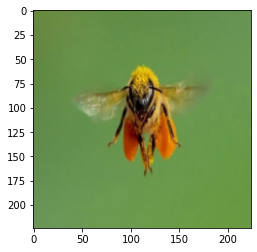

In [37]:
img = transform(img)
plt.imshow(img_convert(img))

In [38]:
img = img.to(device)
img = img.unsqueeze(0)
img.size()

torch.Size([1, 3, 224, 224])

In [39]:
output = model(img)
_, pred_label = torch.max(output, 1)
data_classes[pred_label]

'bee'

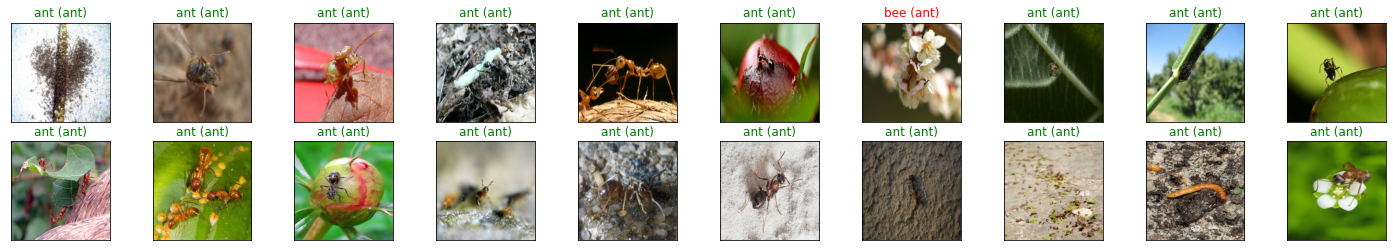

In [30]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
fig = plt.figure(figsize=(25, 4))

outputs = model(images)
_, pred_labels = torch.max(outputs, 1)

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title("{} ({})".format(data_classes[pred_labels[idx]], data_classes[labels[idx]]), color=("green" if pred_labels[idx] == labels[idx] else "red"))